### Retirieveing Data from Census API

We will be using census question groups to retrieve information on a specific topic on block group level from the American Community Survey 5-Year Estimates. 

* Retrieve information
* Format tables
* Merge data with shapefiles for mapping. 

Before we being, we need to have a few things ready:
* API key from Census.gov,  Register here: <a href="https://api.census.gov/data/key_signup.html"> https://api.census.gov/data/key_signup.html </a>
* Shapefiles, download here: <a href="https://www.census.gov/cgi-bin/geo/shapefiles/index.php"> https://www.census.gov/cgi-bin/geo/shapefiles/index.php </a> 
<br>
<i>For this exercise, use 2018 - Block Groups - New York</i>



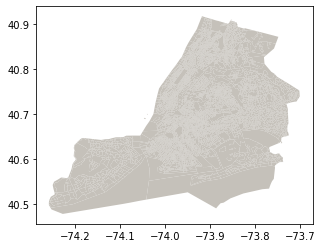

In [4]:
import pandas as pd
import numpy as np
import geopandas as gpd

%matplotlib inline

#Save the API you you will receive to a text file and copy the full path here.
key = open( r"C:\Users\csucuogl\Desktop\WORK\MISC_TEST\census_API.txt" , 'r').read()

#Change the file path to where you have saved the shapefiles.
geo = gpd.read_file( r"C:\Users\csucuogl\Desktop\tl_2019_36_bg")

nyc_counties = ['081','085','047','061','005'] #These are the Geo ID's for the 5 boroughs
geo = geo[ geo['COUNTYFP'].isin(nyc_counties) ] #Filter NYS Block groups to NYC
geo['GEOID'] = '1500000US' + geo['GEOID'] #Format the files to match

#This is a lon list of available column names for ACS. We will use this to format the tables. 
cols = pd.read_json( r'https://api.census.gov/data/2018/acs/acs5/variables.json' ) 

geo.plot( color='#grey' ) #Plot the block groups, block groups are fairly small, this might be fairly heavy.

#### Using ACS questions groups are an easier way of accesing detailed data on a specific topics.

ACS Questions Groups can be found here: <a href="https://api.census.gov/data/2018/acs/acs5/groups.html"> https://api.census.gov/data/2018/acs/acs5/groups.html</a>

Replace the group variable, with the code you would like to use.

<i>group = 'B08303'</i>

In [6]:
group = 'B08303' # B08303 is the commute times
bg = pd.DataFrame()
for i in geo['COUNTYFP'].unique(): #Retrieve Block Group info for each County
    path = r'https://api.census.gov/data/2018/acs/acs5?get=group(' + group + ')&for=block%20group:*&in=state:36%20county:' + str(i) + '&key=' + key
    df = pd.read_json( path )
    bg = bg.append( df )
    
bg.columns = df.loc[0].tolist() #First row as column name
bg=bg.drop( df.index.tolist()[0] , axis = 0)

#Replace NA value codes to Numpy NaN
bg = bg.replace( '-666666666.0' , np.nan)
bg = bg.replace( '-222222222.0' , np.nan)

bg.sample(5)

,GEO_ID,B08303_001E,B08303_001M,B08303_002E,B08303_002M,B08303_003E,B08303_003M,B08303_004E,B08303_004M,B08303_005E,...,B08303_011MA,B08303_011EA,B08303_012MA,B08303_012EA,B08303_013MA,B08303_013EA,state,county,tract,block group
1695,1500000US360810671001,522,121,0,12,16,18,27,22,103,...,None,None,None,None,None,None,36,081,067100,1
5,1500000US360610081006,449,186,0,12,0,12,34,38,0,...,None,None,None,None,None,None,36,061,008100,6
1148,1500000US360610146012,678,209,0,12,0,12,0,12,18,...,None,None,None,None,None,None,36,061,014601,2
403,1500000US360470179001,312,143,0,12,29,48,0,12,13,...,None,None,None,None,None,None,36,047,017900,1
109,1500000US360470291003,612,217,0,12,12,20,14,22,0,...,None,None,None,None,None,None,36,047,029100,3


#### Formatting and Cleaning Data
ACS Data is very clean, but the columnn names are in codes and there are some information that we don't really use for now. 

We will:
* Replace column codes with names. The names are long, so you might not be prefferable. 
* Remove empty columns
* Try to convert every column to numeric
* Shorten column names


In [9]:
label = []
for i,row in cols.iterrows():
    temp = pd.DataFrame( [row['variables']] )
    label.append( temp['label'].values[0] )

cols['label'] = label

label = []
for c in bg.columns.tolist():
    temp = cols[ cols.index == c ]
    if len(temp) != 0:label.append( temp['label'].values[0] )
    else:label.append( c )
bg.columns = label 

bg = bg.dropna( how = 'all' , axis = 1) #Remove columns if there is no value  

bg = bg[ bg.columns[ ~bg.columns.str.contains('EA') ] ] #Remove Annotations Columns
bg = bg[ bg.columns[ ~bg.columns.str.contains('MA') ] ] #Remove Annotations Columns

for c in bg.columns.tolist(): #Try to convert all columns to numeric, if not keep it as it is. 
    try:
        bg[c] = pd.to_numeric( bg[c] )
    except:
        bg[c] = bg[c]

bg.columns = [c.replace( 'Estimate!!Total!!' , '' ) for c in bg.columns.tolist() ]

bg.sample( 3 )

,Geography,Estimate!!Total,B08303_001M,Less than 5 minutes,B08303_002M,5 to 9 minutes,B08303_003M,10 to 14 minutes,B08303_004M,15 to 19 minutes,...,B08303_011M,60 to 89 minutes,B08303_012M,90 or more minutes,B08303_013M,NAME,state,county,tract,block group
316,1500000US360850133011,216,81,0,12,3,6,10,12,39,...,32,3,5,23,19,"Block Group 1, Census Tract 133.01, Richmond C...",36,85,13301,1
71,1500000US360610317030,0,12,0,12,0,12,0,12,0,...,12,0,12,0,12,"Block Group 0, Census Tract 317.03, New York C...",36,61,31703,0
1162,1500000US360610156012,703,389,0,12,20,32,0,12,10,...,221,18,21,0,12,"Block Group 2, Census Tract 156.01, New York C...",36,61,15601,2


#### Join tabular data to the shape files and plot
The column names are very long to type everytime. Save the column names to a variable to be able to use them easier. 

Shapefile data is not projected or filtered, but it is ready to be taken in to a GIS sotfware.
<br> You can save this data as a shp file using read_file: <i>gdf.read_file( 'Your-file-path-here.shp' )</i>

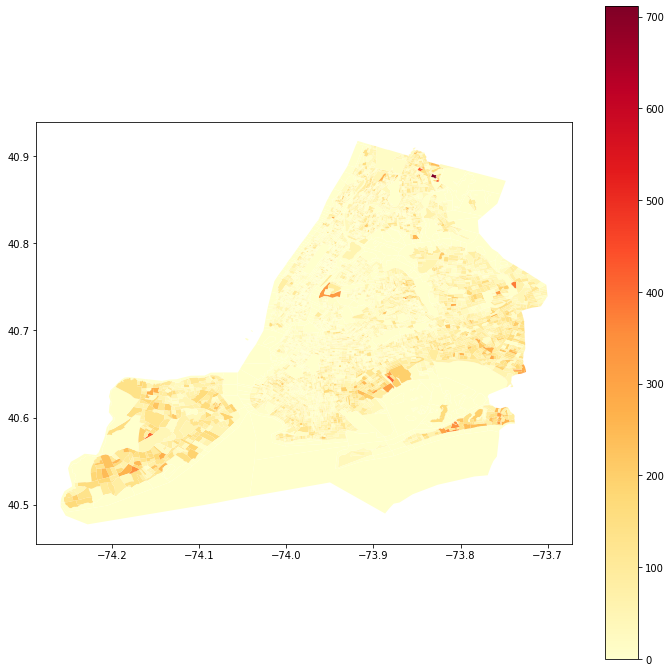

In [15]:
gdf = geo.join( bg.set_index('Geography') , on='GEOID' )
columns_list = gdf.columns.tolist() #There are too long to write
gdf.plot( column = columns_list[37] , cmap='YlOrRd' ,figsize=(12, 12) , legend = True)

#### Here is a basic calculation for calculating percentages of a commutes longer then 45 minutes
Column_list contains the name of the column in a list. I.e. column_list[33] is 'Estimate!!Total!!45 to 59 minutes'

We are adding all commute times longer then 45 minutes and dividing by total. In the map above you will see a n unexpected values around LIC, because the block group in this are is very big. 

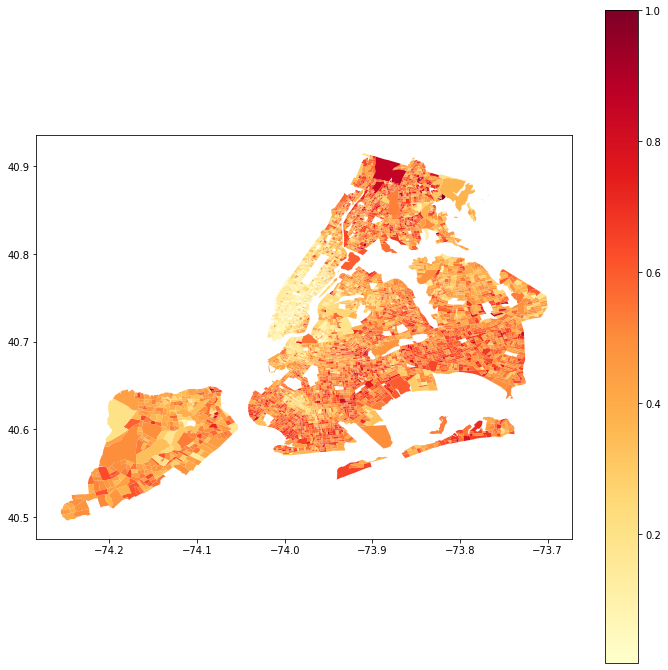

In [18]:
gdf['LongCommute'] = (gdf[columns_list[33]] + gdf[columns_list[35]] + gdf[columns_list[37]]) / gdf[columns_list[13]] 
gdf[gdf['LongCommute']>0].plot( column = 'LongCommute' , cmap='YlOrRd' ,figsize=(12, 12) , legend = True)